In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import sklearn.model_selection
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn import svm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from moviepy.editor import VideoFileClip
from scipy.ndimage.measurements import label
import pickle
%matplotlib inline

### Settings

In [2]:
# keep the settings in this cell for better accessibility during developemnt

# filtering parameters
frames_buffer_size=18 # number of frames to use for noise removal
heatmap_threshold = 10 # min value required for valid features


#Detection parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

# Min and max in y to search in slide_window()
ystart = 400
ystop = 700

xstart = 0  # 350 to ignore the opposite direction lanes
xstop = 1280
# prediction threshold
prediction_threshold = 0.99

input_image_size = 64

# scale factors
# (scale_factor,ystart,ystop)

scales = []
scales.append((1.25,400,500))
scales.append((1.5,400,558))
scales.append((3,400,592))

### Histogram Feature Extraction

In [3]:
# Define a function to compute color histogram features  
def color_hist_test(img, nbins=32): 
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins)
    ghist = np.histogram(img[:,:,1], bins=nbins)
    bhist = np.histogram(img[:,:,2], bins=nbins)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

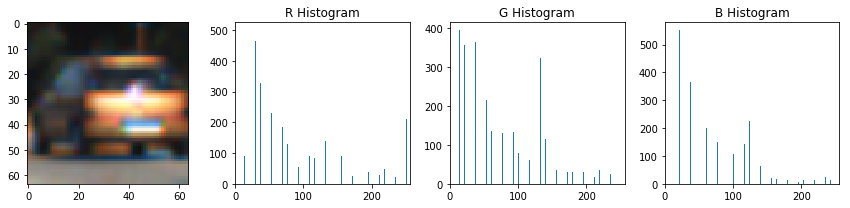

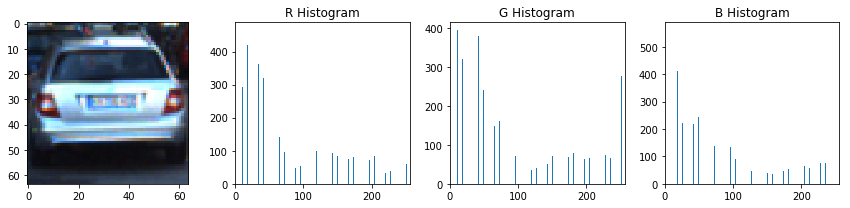

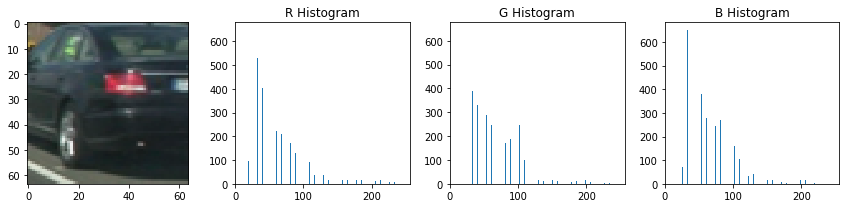

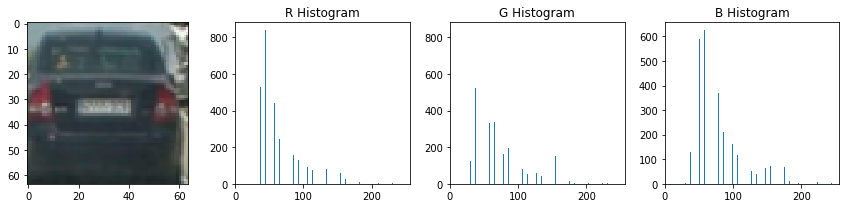

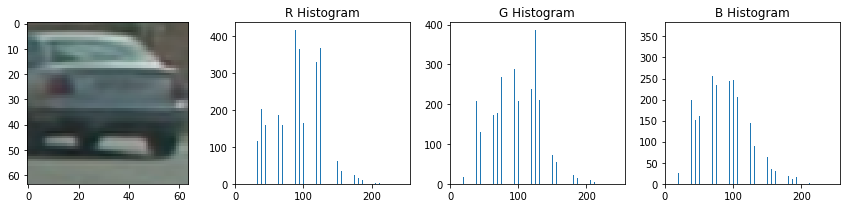

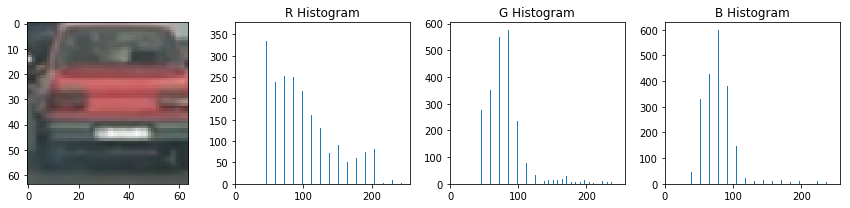

In [4]:
for filename in glob.iglob('vehicle_samples/*.png', recursive=True):
    image = mpimg.imread(filename)
    img = image.astype(np.float32)*255
    # Define a function to compute color histogram features  
   

    rh, gh, bh, bincen, feature_vec = color_hist_test(img, nbins=hist_bins)

    # Plot a figure with all three bar charts
    if rh is not None:
        fig = plt.figure(figsize=(12,3))
        plt.subplot(141)
        plt.imshow(image)
        plt.subplot(142)
        plt.bar(bincen, rh[0])
        plt.xlim(0, 256)
        plt.title('R Histogram')
        plt.subplot(143)
        plt.bar(bincen, gh[0])
        plt.xlim(0, 256)
        plt.title('G Histogram')
        plt.subplot(144)
        plt.bar(bincen, bh[0])
        plt.xlim(0, 256)
        plt.title('B Histogram')
        fig.tight_layout()
    else:
        print('Your function is returning None for at least one variable...')

### Color space exploration

In [5]:
def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=((0, 255), (0, 255), (0, 255))):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

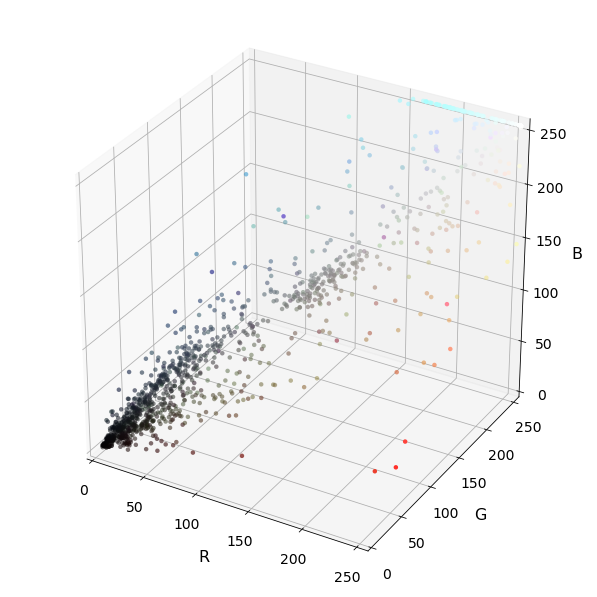

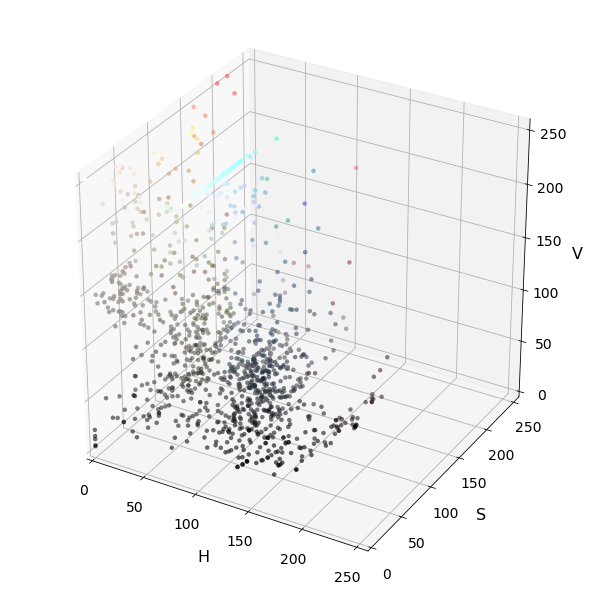

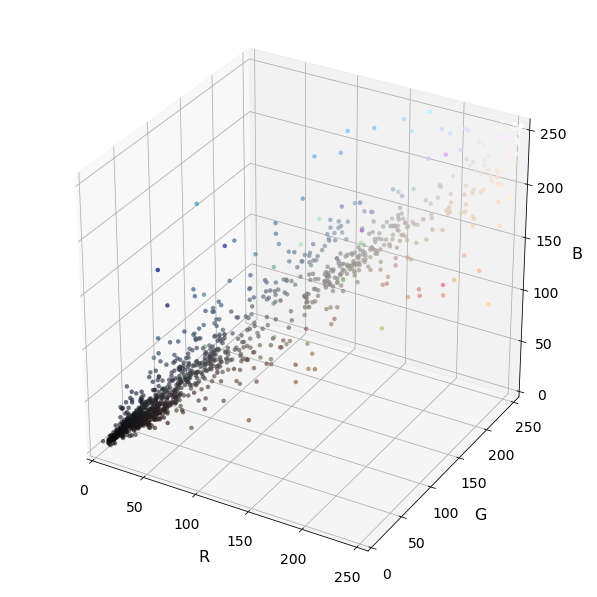

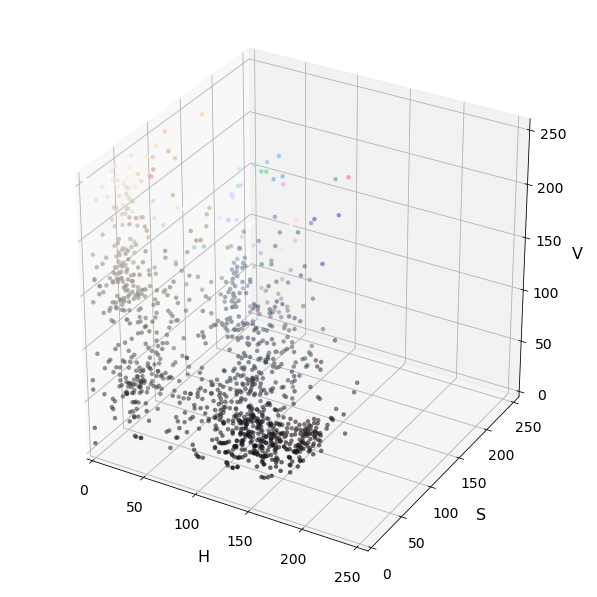

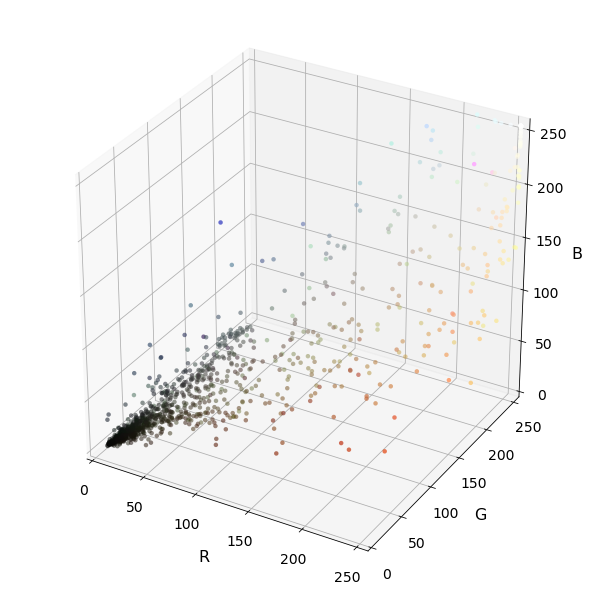

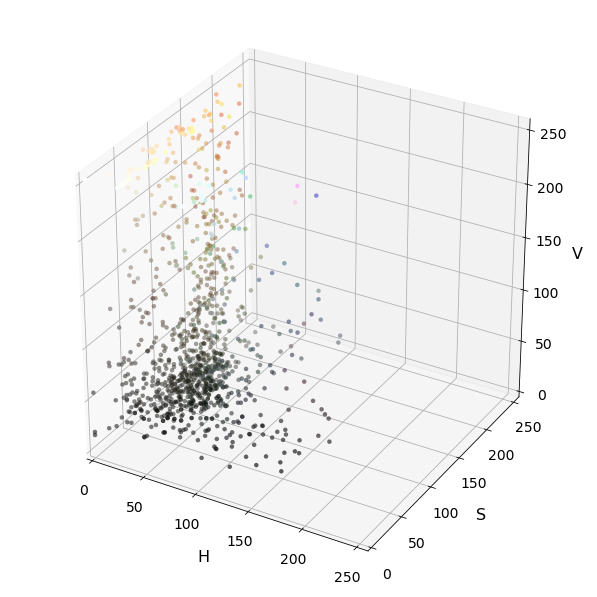

In [6]:
for filename in glob.iglob('color_space_test_images/*.png', recursive=True):
    # Read a color image
    img = cv2.imread(filename)

    # Select a small fraction of pixels to plot by subsampling it
    m = max(img.shape[0], img.shape[1], 64)
    plot_scale =  m/ 64  # at most 64 rows and columns
    img_small = cv2.resize(img, (np.int(img.shape[1] / plot_scale), np.int(img.shape[0] / plot_scale)), interpolation=cv2.INTER_NEAREST)

    # Convert subsampled image to desired color space(s)
    img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
    img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
    img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

    # Plot and show
    plot3d(img_small_RGB, img_small_rgb)
    plt.show()

    plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
    plt.show()

### Spatially Binned Features

In [7]:
def convert_color(img, conv='YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    # iRGB
    return np.copy(img)      

In [8]:
# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
def bin_spatial_test(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    feature_image = convert_color(img,color_space)
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

In [9]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

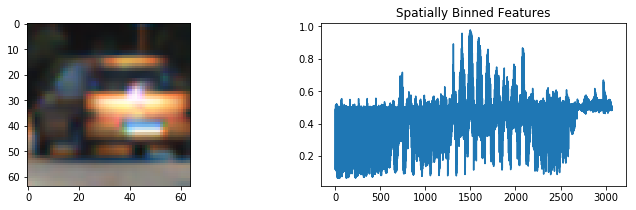

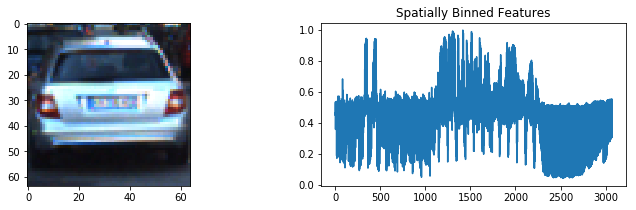

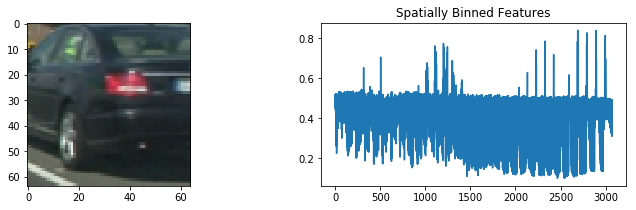

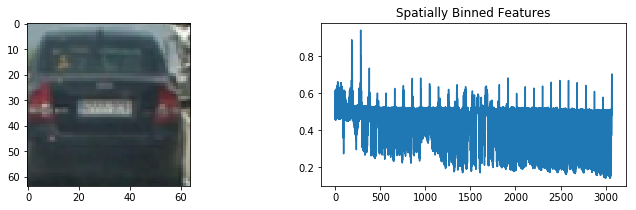

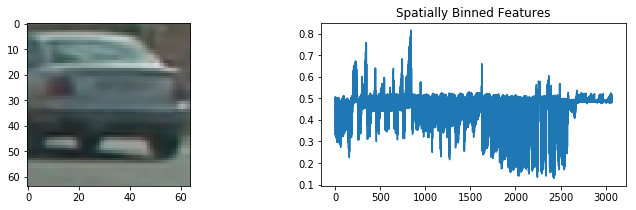

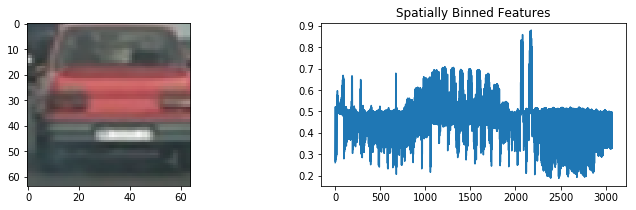

In [10]:
for filename in glob.iglob('vehicle_samples/*.png', recursive=True):
    image = mpimg.imread(filename)    
    feature_vec = bin_spatial_test(image, color_space=color_space, size=spatial_size)
    fig = plt.figure(figsize=(12,3))
    plt.subplot(121)
    plt.imshow(image)
    plt.subplot(122)
    # Plot features
    plt.plot(feature_vec)
    plt.title('Spatially Binned Features')

In [11]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

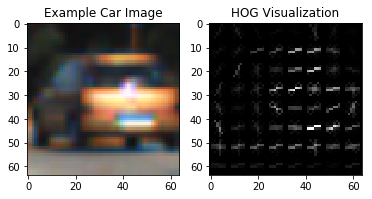

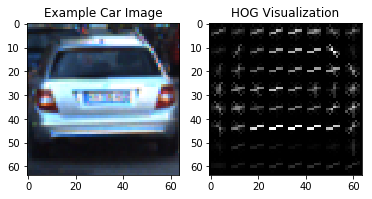

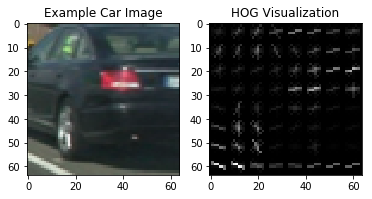

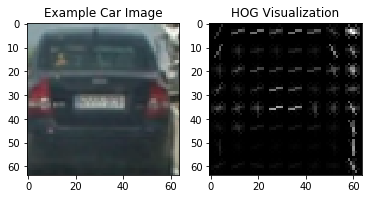

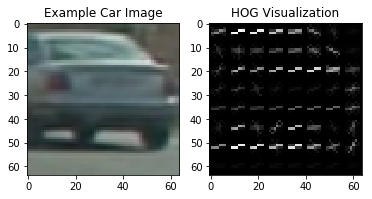

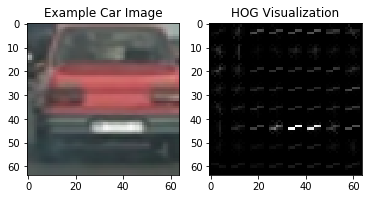

In [12]:
for filename in glob.iglob('vehicle_samples/*.png', recursive=True):
    image = mpimg.imread(filename)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    
    hog_features, hog_image = hog(gray, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=True, feature_vector=False,
                          block_norm="L2-Hys")

    # Plot the examples
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(image, cmap='gray')
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HOG Visualization')

### Combine and Normalize Features

In [13]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_spatial_color_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion 
        feature_image = convert_color(image,color_space)
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features


In [14]:
# Define a function to compute color histogram features
def color_hist(img, nbins=32):  
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### Data preparation

Cars images founds8451
Notcars images founds8974


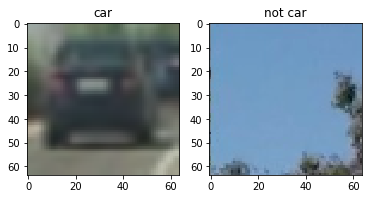

In [15]:
cars=[]
notcars=[]
for filename in glob.iglob('non-vehicles\\**\\*.png', recursive=True):
    notcars.append(filename)
for filename in glob.iglob('vehicles\\**\\*.png', recursive=True):
    cars.append(filename)
print("Cars images founds" + str(len(cars)))
print("Notcars images founds" + str(len(notcars)))

fig = plt.figure()
plt.subplot(121)
plt.title("car")
plt.imshow(mpimg.imread(cars[0]))
plt.subplot(122)
plt.title("not car")
plt.imshow(mpimg.imread(notcars[0]))



### Histogram Oriented Gradient (HOG)

### Color features extraction

In [16]:
t1 = time.time()
car_features = extract_spatial_color_features(cars, cspace=color_space, spatial_size=spatial_size,hist_bins=hist_bins)
t2 = time.time()
print(str(round(t2-t1, 2)), 'Seconds to train car_features')

22.69 Seconds to train car_features


In [17]:
t1 = time.time()
notcar_features = extract_spatial_color_features(notcars, cspace='RGB', spatial_size=spatial_size,hist_bins=hist_bins)
t2 = time.time()
print(round(t2-t1, 2), 'Seconds to train car_features')

46.14 Seconds to train car_features


### Train classifier with color features

In [18]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using spatial binning of:',spatial_size[0],
    'and', hist_bins,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 3168
20.36 Seconds to train SVC...


### Test color features classifier

In [19]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  0.9463
My SVC predicts:  [1. 0. 0. 1. 0. 0. 1. 0. 1. 1.]
For these 10 labels:  [1. 0. 0. 1. 0. 0. 1. 0. 1. 1.]
0.02301 Seconds to predict 10 labels with SVC


### HOG features extraction

In [20]:
def extract_HOG_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        feature_image = convert_color(image,cspace)

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features


In [21]:
t=time.time()
car_features = extract_HOG_features(cars, cspace=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

t2=time.time()
print(str(round(t2-t,2)) + ' seconds to extract car HOG features')

105.94 seconds to extract car HOG features


In [22]:
t1=time.time()

notcar_features = extract_HOG_features(notcars, cspace=color_space, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2=time.time()
print(str(round(t2-t,2)) + 'seconds to extract notcar HOG features')

195.65seconds to extract notcar HOG features


### Train classifier with HOG features

In [23]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(str(round(t2-t,2)) + 'Seconds to train SVC...')


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
19.47Seconds to train SVC...


### Test classifier

In [24]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(str(round(t2-t,5)) + 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  0.9822
My SVC predicts:  [1. 1. 0. 0. 1. 1. 1. 0. 0. 1.]
For these 10 labels:  [1. 1. 0. 0. 1. 1. 1. 0. 0. 1.]
0.01051Seconds to predict 10 labels with SVC


### Sliding windows

In [25]:
# Define a function that takes an image,
# start and stop positions in both x and y,
# window size (x and y dimentions),
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = np.int(img.shape[0]/2)
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positins to
    window_list = []
    # Loop through finding x and y window postions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window positon
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

### Scale estimation

In [26]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    #Return the image copy with boxes drawn
    return imcopy

In [27]:
def test_window_area(scale,ystart,ystop,xpos,ypos,imagefile,color):
    image = mpimg.imread(imagefile)  
    window_size = int(input_image_size*scale)   
    image = draw_boxes(image,[((xpos,ypos),(xpos + window_size,ypos+window_size))])  # scale = 4
    # top search limit
    cv2.line(image,(0,ystart),(1280,ystart),color,5)
    # bottom search limit
    cv2.line(image,(0,ystop),(1280,ystop),color,5) 
    window_size = int(input_image_size*scale)
    image = draw_boxes(image,[((xpos,ypos),(xpos+window_size,ypos+window_size))])
    fig=plt.figure()
    plt.title('Scale = ' + str(scale))
    plt.imshow(image)

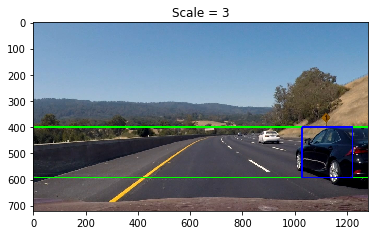

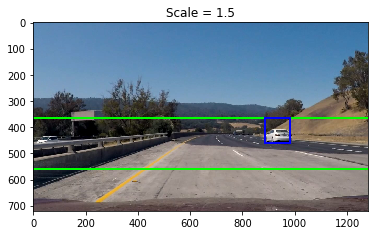

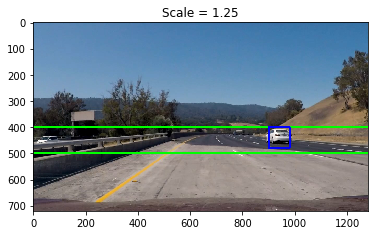

In [28]:
color = (0,255,0) # green
# tests for optimum scale factor

# scale = 3
test_window_area(3,400,592,1028,400,'sliding_window_test/sliding_close.jpg',color)

# scale = 1.5
test_window_area(1.5,364,558,886,364,'sliding_window_test/sliding_long.jpg',color)

# scale = 1.25
test_window_area(1.25,400,500,900,400,'sliding_window_test/sliding_long.jpg',color)

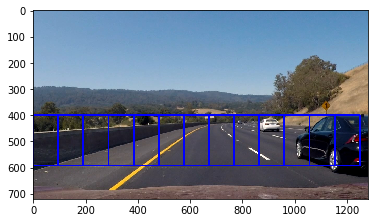

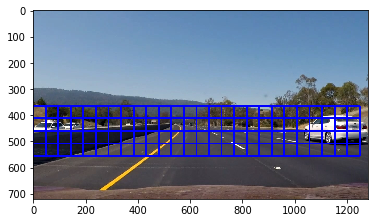

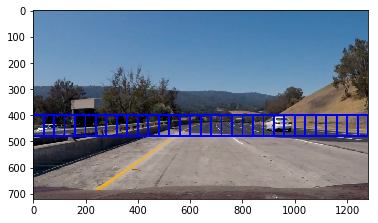

In [29]:
image = mpimg.imread('sliding_window_test/sliding_close.jpg')  
windows = slide_window(image, x_start_stop=[xstart, None], y_start_stop=[400,592], xy_window=(3*64,3*64), xy_overlap=(0.5,0.5))
img = draw_boxes(image, windows)
fig = plt.figure()
plt.imshow(img)

image = mpimg.imread('sliding_window_test/sliding_medium.jpg')  
windows = slide_window(image, x_start_stop=[xstart, None], y_start_stop=[364,558], xy_window=(int(1.5*64),int(1.5*64)), xy_overlap=(0.5,0.5))
img = draw_boxes(image, windows)
fig = plt.figure()
plt.imshow(img)

image = mpimg.imread('sliding_window_test/sliding_long.jpg')  
windows = slide_window(image, x_start_stop=[xstart, None], y_start_stop=[400,500], xy_window=(int(1.25*64),int(1.25*64)), xy_overlap=(0.5,0.5))

img = draw_boxes(image, windows)
fig = plt.figure()
plt.imshow(img)

### Feature extraction

In [30]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    

In [31]:

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):
    #1) Define an empty list to receice features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    feature_image = convert_color(img,color_space)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True))
            hog_features = np.concatenate(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel],orient,
                            pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel],orient,
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

In [32]:
# Define a function you will pass an image
# and the list of windows to be searched (output of slide_window())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction >prediction_threshold:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [33]:
t1 = time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t1, 2), 'Seconds to compute notcar_features')

71.37 Seconds to compute notcar_features


In [34]:
t1 = time.time()
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t1, 2), 'Seconds to compute notcar_features')

67.49 Seconds to compute notcar_features


### Train features

In [35]:
### Setup the SVM
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)   

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell,', cell_per_block,'cells per block',
     hist_bins,'histogram bins, and', spatial_size, 'spatial sampling')

print('Feature vector length:', len(X_train[0]))


Using: 9 orientations 8 pixels per cell, 2 cells per block 32 histogram bins, and (32, 32) spatial sampling
Feature vector length: 8460


In [36]:
# Use a linear SVC 
# svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
#parameters = {'kernel':['linear','rbf'], 'C':[0.1, 0.5, 1]}
#svr = svm.SVC()
#clf = GridSearchCV(svr, parameters)
#clf.fit(X_train, y_train)

svc = LinearSVC()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

14.61 Seconds to train SVC...


In [37]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.992


### Visualize features

In [38]:
# Deifine a function for plotting multiple images
def visualize(fig, rows, cols, imgs):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims<3:
            plt.imshow(img,cmap="hot")
            
        else:
            plt.imshow(img)
            

In [39]:
def get_heatmap(heatmap, windows):
    for window in windows:
        heatmap[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 1
    return heatmap

In [40]:
def apply_threshold(heatmap, threshold):
    if threshold >0:
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [41]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

### Heat map example

In [42]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars_heatmap(img, scale = 1.5,thresh=heatmap_threshold, ystart = ystart, ystop = ystop, xstart = xstart, xstop=xstop):
    heatmap = np.zeros_like(img[:,:,0])
    hot_windows = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64 # cell_per_block * pix_per_cell
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction > prediction_threshold:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,1),6) #255 
                #print(xbox_left,ytop_draw,win_draw)
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart,xbox_left:xbox_left+win_draw]+=1
        if thresh>0:
            heatmap = apply_threshold(heatmap,thresh)  # clean some noise
    return heatmap

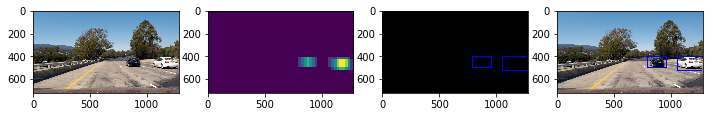

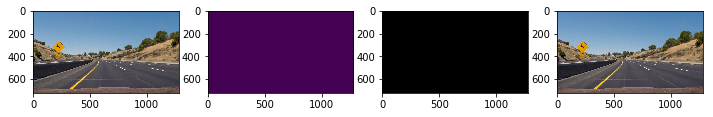

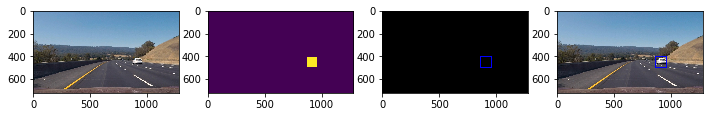

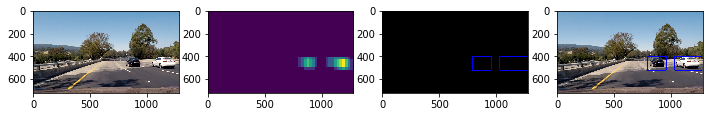

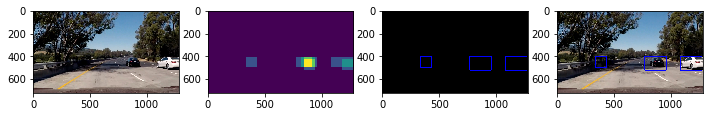

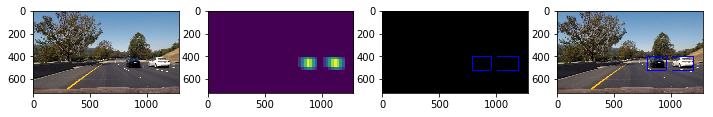

In [43]:
for filename in glob.iglob('test_images/*.jpg', recursive=True):
    # Read a color image
    img = cv2.imread(filename)
    fig = plt.figure(figsize = (12,3))
    img=img[...,::-1]
    plt.subplot(141)
    plt.imshow(img)
    plt.subplot(142)
    heatmap = find_cars_heatmap(img,1.5,0)
    plt.imshow(heatmap)
    plt.subplot(143)
    labels = label(heatmap)    
    draw_img = draw_labeled_bboxes(np.zeros_like(img), labels)
    plt.imshow(draw_img)
    plt.subplot(144)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    plt.imshow(draw_img)

### Final pipeline

In [44]:
frames_buffer=[]                                      # buffer to store the recent frames. The buffer size is frames_buffer_size.
def filterHeatmap(new_heatmap, threshold=0, frames_buffer_size = frames_buffer_size):            # use info from the last frames to remove noise and false positives
    global frames_buffer
    
    length = len(frames_buffer)
    #threshold = length * normalized_threshold         # each heat map pixel value is added one time normalized_thresholdfor each frame so I have to compensate that 
    if length >= frames_buffer_size:                  # if the buffer is full
        frames_buffer.pop(0)                          # remove the oldest frame
    frames_buffer.append(new_heatmap)                 # add the new frame to the buffer
    heatmap = sum(frames_buffer)                      # combine the heatmaps into a single heatmap  
    thresholded_heatmap = apply_threshold(heatmap,threshold)  # clean some noise
    
    return thresholded_heatmap

In [45]:
def find_cars(img, scales = scales):
    heatmap = np.zeros_like(img[:,:,0])
    for scale in scales:
        heatmap += find_cars_heatmap(img, scale = scale[0],ystart=scale[1],ystop=scale[2], thresh = 0)              
    filtered_heatmap = filterHeatmap(heatmap,threshold =  heatmap_threshold, frames_buffer_size = frames_buffer_size )       
    labels = label(filtered_heatmap)                        
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [46]:
# close the video clip and release the resources. Otherwise an "invalid handler" error will raise 
# when I try to process the video a second time. 
def close_clip(clip):  
        try:
                clip.reader.close()
                del clip.reader
                if clip.audio != None:
                        clip.audio.reader.close_proc()
                        del clip.audio
                del clip                

        except Exception as e:
                sys.exc_clear()

### Process the test video

In [47]:
frames_buffer=[]      # flush the frames buffer to avoid garbage from previously detected cars
clip = VideoFileClip("test_video.mp4")
test_clip = clip.fl_image(find_cars)
test_clip.write_videofile('test_output1.mp4', audio=False)
close_clip(clip)

[MoviePy] >>>> Building video test_output1.mp4
[MoviePy] Writing video test_output1.mp4


 97%|████████████████████████████████████████▉ | 38/39 [00:29<00:00,  1.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output1.mp4 



In [48]:
%%HTML
<video controls width="100%" controls>
  <source src="test_output1.mp4" type="video/mp4">
</video>

In [49]:
frames_buffer=[]      # flush the frames buffer to avoid garbage from previously detected cars
clip = VideoFileClip("small.mp4")
test_clip = clip.fl_image(find_cars)
%time test_clip.write_videofile('small_output2.mp4', audio=False)
close_clip(clip)

[MoviePy] >>>> Building video small_output2.mp4
[MoviePy] Writing video small_output2.mp4


100%|████████████████████████████████████████| 151/151 [01:58<00:00,  1.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: small_output2.mp4 

Wall time: 1min 59s


In [50]:
%%HTML
<video controls width="100%" controls>
  <source src="small_output2.mp4" type="video/mp4">
</video>

In [51]:
frames_buffer=[]      # flush the frames buffer to avoid garbage from previously detected cars
clip = VideoFileClip("project_video.mp4")
test_clip = clip.fl_image(find_cars)
%time test_clip.write_videofile('project_video_output.mp4', audio=False)
close_clip(clip)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [16:16<00:00,  1.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 16min 17s


In [52]:
%%HTML
<video controls width="100%" controls>
  <source src="project_video_output.mp4" type="video/mp4">
</video>